# Análisis - NILMTK-DF

En primer lugar, se analizan metadatos y datos del dataset cuya estructura se basa en el formato NILMTK-DF.

Librerías y otros ajustes:

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib import rcParams
from nilmtk.utils import print_dict
from nilmtk import DataSet
import warnings
warnings. filterwarnings("ignore")
plt.style.use('bmh')

La primera tarea es la importación del dataset que se encuentra en formato HDF5 en la carpeta `C:/data`. Se carga el archivo DEPS.h5 que contiene los datos recopilados y metadatos del dataset.

In [2]:
deps = DataSet('C:/data/DEPS.h5')

## MeterGroup y ElecMeter

En este punto, todos los metadatos se han cargado en la memoria pero ninguno de los datos de energía se ha cargado.
Cada edificio tiene un atributo "elec" que es un objeto "MeterGroup" que contiene los medidores "ElecMeter".

In [3]:
elec = deps.buildings[1].elec #todos los medidores del dataset
elec

MeterGroup(meters=
  ElecMeter(instance=1, building=1, dataset='DEPS', site_meter, appliances=[])
  ElecMeter(instance=2, building=1, dataset='DEPS', appliances=[])
  ElecMeter(instance=3, building=1, dataset='DEPS', appliances=[])
  ElecMeter(instance=4, building=1, dataset='DEPS', appliances=[])
  ElecMeter(instance=5, building=1, dataset='DEPS', appliances=[Appliance(type='light', instance=1)])
  ElecMeter(instance=6, building=1, dataset='DEPS', appliances=[Appliance(type='light', instance=2)])
  ElecMeter(instance=7, building=1, dataset='DEPS', appliances=[Appliance(type='air conditioner', instance=1)])
  ElecMeter(instance=8, building=1, dataset='DEPS', appliances=[Appliance(type='air conditioner', instance=2)])
  ElecMeter(instance=9, building=1, dataset='DEPS', appliances=[Appliance(type='air conditioner', instance=3)])
  ElecMeter(instance=10, building=1, dataset='DEPS', appliances=[Appliance(type='server computer', instance=1)])
)

### Etiquetas de dispositivos

In [4]:
labels = pd.DataFrame({'Instances': list(range(1,11)),
                       'Meters': ['Main_RST', 'Main_R', 'Main_S', 'Main_T', 'Lights_1','Lights_2', 'HVAC_1', 'HVAC_2', 'HVAC_4', 'Rack']})
Meters={}
for x in range(len(labels)): Meters[elec[x+1]]=labels['Meters'][x]

##  Metadatos

Explorando metadatos

In [5]:
print_dict(deps.metadata)  #metadatos del dataset

In [6]:
print_dict(deps.buildings[1].metadata) #Información del edificio 1 (instancia 1)

In [7]:
print_dict(elec[7].get_metadata()) #metadatos de ElecMeter 7 o elec[7]
#también print_dict(elec[7].device)

Otras consultas

In [8]:
elec.available_physical_quantities() #todas las medidas del MeterGroup

['voltage', 'current', 'power']

In [9]:
elec[7].available_physical_quantities() #medidas de ElecMeter 7 (HVAC_1)

['voltage', 'current', 'power']

In [10]:
elec[7].available_ac_types('power') #medidas de potencia de ElecMeter 7 

['active', 'reactive']

Del atributo 'elec' se puede obtener información de los medidores

En caso de consultar por una medición en específico, se pueden usar los siguientes tipos de mediciones tanto en ‘available_physical_quantities’ como en ‘available_ac_types’: 'power', 'energy', 'cumulative energy', 'voltage', 'current', 'pf', 'frequency', 'power factor', 'state', 'phase angle'.

### Resumen de mediciones

In [11]:
print('Mediciones disponibles - Dataset: '+str(elec.available_physical_quantities()))
print('Mediciones de Potencia disponibles - Dataset: '+str(elec.available_ac_types('power')))

print('\nMedidas disposnibles por cada medidor:')
for x in range(len(labels)-1):
    print(str(labels['Meters'][x])+': '+str(elec[x+1].available_physical_quantities()))

print('\nMedidas de potencia por cada medidor:')  
for x in range(len(labels)-1):
    print(str(labels['Meters'][x])+': '+str(elec[x+1].available_ac_types('power')))

Mediciones disponibles - Dataset: ['voltage', 'current', 'power']
Mediciones de Potencia disponibles - Dataset: ['active', 'reactive']

Medidas disposnibles por cada medidor:
Main_RST: ['power']
Main_R: ['voltage', 'current', 'power']
Main_S: ['voltage', 'current', 'power']
Main_T: ['voltage', 'current', 'power']
Lights_1: ['power']
Lights_2: ['power']
HVAC_1: ['voltage', 'current', 'power']
HVAC_2: ['voltage', 'current', 'power']
HVAC_4: ['voltage', 'current', 'power']

Medidas de potencia por cada medidor:
Main_RST: ['active', 'reactive']
Main_R: ['active', 'reactive']
Main_S: ['active', 'reactive']
Main_T: ['active', 'reactive']
Lights_1: ['active']
Lights_2: ['active']
HVAC_1: ['active', 'reactive']
HVAC_2: ['active', 'reactive']
HVAC_4: ['active', 'reactive']


Los dispositivos se identifican de forma única dentro de un edificio por un tipo (luces, televisión, etc.) y un número de instancia. Si no se especifica un número de instancia, ElecMeter recupera la instancia 1.

### Esquema de red

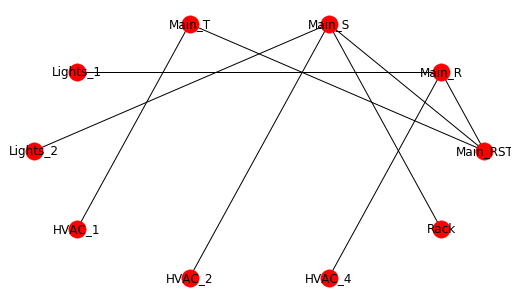

In [12]:
rcParams['figure.figsize'] = (7, 4)
fig = elec.draw_wiring_graph_2(show_meter_labels=False)

#etiquetas, opcional
pos = nx.shell_layout(fig[0])
nx.draw_networkx_labels(fig[0], pos, labels=Meters)
#guarda gráfico
plt.savefig('C:/data/images/2.1_Network.svg', bbox_inches='tight', transparent=True)
pass

Esta función presenta problemas con Matplotlib 3.3.0 (por defecto en NILMTK), por lo que se recomienda reemplazarla por versiones 3.1.x en caso de usarla (fuente: https://github.com/nilmtk/nilmtk/issues/868).

Se ha modificado la función original para poder graficar correctamente las etiquetas, dando paso a `elec.draw_wiring_graph_2`

## Carga de datos en memoria

Intervalos de tiempo en que se registran datos: `elec[1]`

Timestamp en timezone Europe/madrid https://www.epochconverter.com/

In [13]:
elec.get_timeframe()

TimeFrame(start='2020-02-24 00:00:00+01:00', end='2020-03-06 23:59:59+01:00', empty=False)

Una manera rápida de cargar varios datos de medidores en un DataFrame es utilizar la función `dataframe_of_meters` e indicar cual medida se desea importar desde el MeterGroup.

In [14]:
Devices = elec.select(instance=[5,6,7,8,9,10])  #nuevo MeterGroup de dispositivos
df = Devices.dataframe_of_meters(ac_type='active') #crea Dataframe
#etiquetas
df.columns = [list(labels['Meters'][4:10])]
df

,Lights_1,Lights_2,HVAC_1,HVAC_2,HVAC_4,Rack
2020-02-24 00:00:00+01:00,0.0,0.0,69.860001,71.540001,9.11,110.699997
2020-02-24 00:00:01+01:00,0.0,0.0,69.699997,71.370003,9.06,111.300003
2020-02-24 00:00:02+01:00,0.0,0.0,69.760002,71.330002,9.44,112.300003
2020-02-24 00:00:03+01:00,0.0,0.0,70.019997,71.570000,9.11,111.500000
2020-02-24 00:00:04+01:00,0.0,0.0,69.680000,71.360001,9.11,111.599998
...,...,...,...,...,...,...
2020-03-06 23:59:55+01:00,0.0,0.0,66.360001,65.779999,9.36,113.699997
2020-03-06 23:59:56+01:00,0.0,0.0,65.839996,64.809998,9.02,113.300003
2020-03-06 23:59:57+01:00,0.0,0.0,65.940002,64.839996,9.27,113.699997
2020-03-06 23:59:58+01:00,0.0,0.0,66.169998,64.889999,9.03,113.699997


In [15]:
df.info() #información del DataFrame

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1036800 entries, 2020-02-24 00:00:00+01:00 to 2020-03-06 23:59:59+01:00
Freq: S
Data columns (total 6 columns):
(Lights_1,)    1036800 non-null float32
(Lights_2,)    1036800 non-null float32
(HVAC_1,)      1036800 non-null float32
(HVAC_2,)      1036800 non-null float32
(HVAC_4,)      1036800 non-null float32
(Rack,)        1036800 non-null float32
dtypes: float32(6)
memory usage: 31.6 MB


Tambien se pueden asignar individualmente datos de medidores en un Dataframe

In [16]:
t0 = '2020-03-02 20:45:00+01:00' #tiempo inicial
t1 = '2020-03-02 21:30:00+01:00' #tiempo final
df_HVAC_1 = next(elec[7].load())[t0:t1] #DataFrame medidor HVAC_1
df_HVAC_1

physical_quantity         current     voltage      power           
type                                            reactive     active
2020-03-02 20:45:00+01:00     0.5  226.410004  31.690001  97.010002
2020-03-02 20:45:01+01:00     0.5  226.440002  31.600000  97.080002
2020-03-02 20:45:02+01:00     0.5  226.419998  31.650000  97.050003
2020-03-02 20:45:03+01:00     0.5  226.399994  31.570000  96.930000
2020-03-02 20:45:04+01:00     0.5  226.380005  31.660000  97.160004
...                           ...         ...        ...        ...
2020-03-02 21:29:55+01:00     0.5  228.100006  32.189999  97.220001
2020-03-02 21:29:56+01:00     0.5  228.199997  32.279999  97.489998
2020-03-02 21:29:57+01:00     0.5  228.110001  32.220001  97.160004
2020-03-02 21:29:58+01:00     0.5  228.070007  32.270000  97.349998
2020-03-02 21:29:59+01:00     0.5  228.110001  32.220001  97.260002

[2576 rows x 4 columns]

Gráficos

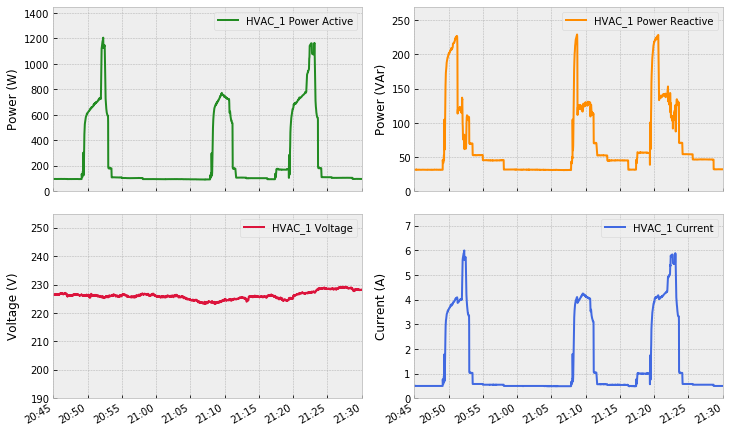

In [17]:
rcParams['figure.figsize'] = (12, 8)
fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2, sharex=True, gridspec_kw={'hspace': 0.12, 'wspace': 0.17})

df_HVAC_1['power', 'active'].plot(ax=ax1,color='forestgreen')
ax1.legend(['HVAC_1 Power Active'])
ax1.set(ylabel='Power (W)')
ax1.set_ylim([0,1450])

df_HVAC_1['power', 'reactive'].plot(ax=ax2,color='darkorange')
ax2.legend(['HVAC_1 Power Reactive'])
ax2.set(ylabel='Power (VAr)')
ax2.set_ylim([0,270])

df_HVAC_1['voltage'].plot(ax=ax3,color='crimson')
ax3.legend(['HVAC_1 Voltage'])
ax3.set(ylabel='Voltage (V)')
ax3.set_ylim([190,255])

df_HVAC_1['current'].plot(ax=ax4,color='royalblue')
ax4.legend(['HVAC_1 Current'])
ax4.set(ylabel='Current (A)')
ax4.set_ylim([0,7.5])

ax1.set(xlim=('2020-03-02 20:44:59+01:00','2020-03-02 21:30:01+01:00'))
ax1.minorticks_off()
ax1.set_xticklabels(['20:45','20:50','20:55','21:00','21:05','21:10','21:15','21:20','21:25','21:30'])
fig.align_ylabels([(ax1,ax2,ax3,ax4)])

#guarda gráfico
plt.savefig('C:/data/images/2.2_HVAC_1.svg', bbox_inches='tight', transparent=True)
pass

### Cambio en el muestreo de datos

Al cambiar el muestro de datos, NILMTK utiliza por defecto el método mean o media aritmética el cual calculará un promedio de los valores que se encuentren de la serie de tiempo, divididos en grupos correspondientes al nuevo periodo de muestreo. Además de este método se pueden especificar otros tales como el primer dato válido (first), la mediana (median), el valor más cercano (nearest), o utilizar el valor inmediatamente posterior (ffill o pad), entre otros.

In [18]:
m = 1 #meter
method1 = {'how': 'mean'}
method2 = {'how': 'median'}
method3 = {'how': 'first'}

#medición original, cada 1 segundo
df_1s   = next(elec[m].load(ac_type='active',sample_period=1,       resample_kwargs=method1))
#resamples
df1_10s  = next(elec[m].load(ac_type='active', sample_period=10,     resample_kwargs=method1))
df1_30s  = next(elec[m].load(ac_type='active', sample_period=30,     resample_kwargs=method1))
df1_60s  = next(elec[m].load(ac_type='active', sample_period=60*1,   resample_kwargs=method1))
df1_5m   = next(elec[m].load(ac_type='active', sample_period=60*5,   resample_kwargs=method1))
df1_10m  = next(elec[m].load(ac_type='active', sample_period=60*10,  resample_kwargs=method1))
df1_15m  = next(elec[m].load(ac_type='active', sample_period=60*15,  resample_kwargs=method1))
df1_30m  = next(elec[m].load(ac_type='active', sample_period=60*30,  resample_kwargs=method1))

df2_10s  = next(elec[m].load(ac_type='active', sample_period=10,    resample_kwargs=method2))
df2_30s  = next(elec[m].load(ac_type='active', sample_period=30,    resample_kwargs=method2))
df2_60s  = next(elec[m].load(ac_type='active', sample_period=60*1,  resample_kwargs=method2))
df2_5m   = next(elec[m].load(ac_type='active', sample_period=60*5,  resample_kwargs=method2))
df2_10m  = next(elec[m].load(ac_type='active', sample_period=60*10,  resample_kwargs=method2))
df2_15m  = next(elec[m].load(ac_type='active', sample_period=60*15,  resample_kwargs=method2))
df2_30m  = next(elec[m].load(ac_type='active', sample_period=60*30,  resample_kwargs=method2))

df3_10s  = next(elec[m].load(ac_type='active', sample_period=10,    resample_kwargs=method3))
df3_30s  = next(elec[m].load(ac_type='active', sample_period=30,    resample_kwargs=method3))
df3_60s  = next(elec[m].load(ac_type='active', sample_period=60*1,  resample_kwargs=method3))
df3_5m   = next(elec[m].load(ac_type='active', sample_period=60*5,  resample_kwargs=method3))
df3_10m  = next(elec[m].load(ac_type='active', sample_period=60*10,  resample_kwargs=method3))
df3_15m  = next(elec[m].load(ac_type='active', sample_period=60*15,  resample_kwargs=method3))
df3_30m  = next(elec[m].load(ac_type='active', sample_period=60*30,  resample_kwargs=method3))

#dataframe completo
dfs1=[df_1s,df1_10s,df1_30s,df1_60s,df1_5m,df1_10m,df1_15m,df1_30m]
#dataframe completo
dfs2=[df_1s,df2_10s,df2_30s,df2_60s,df2_5m,df2_10m,df2_15m,df2_30m]
#dataframe completo
dfs3=[df_1s,df3_10s,df3_30s,df3_60s,df3_5m,df3_10m,df3_15m,df3_30m]

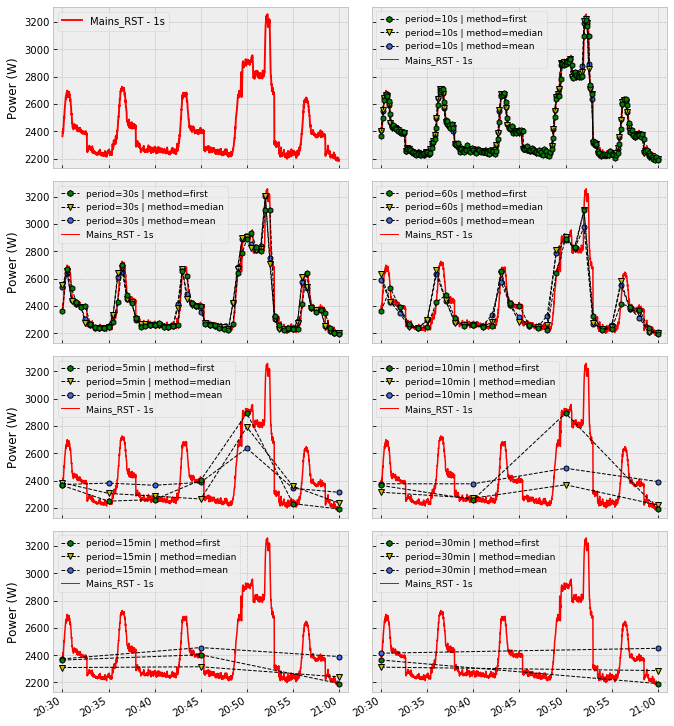

In [19]:
rcParams['figure.figsize'] = (11, 14)
t0 = '2020-03-02 20:30:00+01:00'
t1 = '2020-03-02 21:00:00+01:00'
labels_ = ['Mains_RST - 1s','10s','30s','60s','5min','10min','15min','30min']
fig, ((ax1, ax2), (ax3, ax4),(ax5, ax6),(ax7, ax8)) = plt.subplots(4, 2, sharex=True, sharey=True,
                                                                   gridspec_kw={'hspace': 0.08, 'wspace': 0.08})
i = 1
for ax in fig.get_axes():   
    if ax == ax1:
        df_1s[t0:t1].plot(ax=ax,linewidth=1.9,color='r')
        ax.legend([labels_[0]])               
    else:
        import matplotlib.lines as mlines
        df_1s[t0:t1].plot(ax=ax,linewidth=1.5,color='r') 
        dfs1[i][t0:t1].plot(ax=ax,lw=1, c='k', ls='--', marker="o", markersize=5, markerfacecolor='royalblue')    
        dfs2[i][t0:t1].plot(ax=ax,lw=1, c='k', ls='--', marker="v", markersize=5.5, markerfacecolor='y')
        dfs3[i][t0:t1].plot(ax=ax,lw=1, c='k', ls='--', marker="h", markersize=5.5, markerfacecolor='g')
        #etiquetas
        line0 = mlines.Line2D([], [], lw=1, c='red', label= labels_[0])
        line1 = mlines.Line2D([], [], lw=1, c='k', ls='--', marker="o", markersize=5.5,
                              markerfacecolor='royalblue', label='period='+labels_[i]+' | method=mean')
        line2 = mlines.Line2D([], [], lw=1, c='k', ls='--', marker="v", markersize=6,
                              markerfacecolor='y', label='period='+labels_[i] + ' | method=median')
        ax.legend(handles=[line2, line1, line0], fontsize=9)
        line3 = mlines.Line2D([], [], lw=1, c='k', ls='--', marker="h", markersize=6,
                              markerfacecolor='g', label='period='+labels_[i] + ' | method=first')
        ax.legend(handles=[line3, line2, line1, line0], fontsize=9)
        plt.setp(ax.xaxis.get_majorticklabels(), ha='right')
        i = i+1
    ax.set(ylabel='Power (W)')

ax1.set(xlim=('2020-03-02 20:29:00+01:00','2020-03-02 21:01:00+01:00'))
ax1.minorticks_off()
ax1.set_xticklabels(['20:30','20:35','20:40','20:45','20:50','20:55','21:00'])

#guarda gráfico
plt.savefig('C:/data/images/2.3_Resample.svg', bbox_inches='tight', transparent=True)
pass

Marcadores: 
- https://matplotlib.org/3.1.0/api/markers_api.html

Colores:
- https://matplotlib.org/api/colors_api.html?highlight=colors#module-matplotlib.colors
- https://matplotlib.org/3.1.0/gallery/color/named_colors.html